In [1]:
import os
import xml.etree.ElementTree as ET

def get_bbs(xml_path):
  tree = ET.parse(xml_path)
  root = tree.getroot()
  for obj in root.iter("object"):
      # Filter only objects with the name "کل ناحیه پلاک"
      cls = obj.find("name").text
      if cls != "کل ناحیه پلاک":
          continue  # Skip objects that do not match the desired class

      xmlbox = obj.find("bndbox")
      if xmlbox is not None:
          try:
              box = (
                  float(xmlbox.find("xmin").text),
                  float(xmlbox.find("xmax").text),
                  float(xmlbox.find("ymin").text),
                  float(xmlbox.find("ymax").text)
              )
              bbox_pil = (
                box[0],
                box[2],
                box[1],
                box[3]
              )
              return bbox_pil
          except (ValueError, AttributeError) as e:
              print(f"Error processing bounding box in {xml_path}: {e}")
              continue
      else:
          print(f"Warning: <bndbox> element not found in {xml_path}. Skipping this object.")

def get_all_bbs(xml_dir):
    bbs_dict = {}
    for xml_file in os.listdir(xml_dir):
      if xml_file.endswith(".xml"):
          image_name = xml_file.replace(".xml", "")

          bbs_dict[image_name] = get_bbs(os.path.join(xml_dir, xml_file))

    return bbs_dict

In [2]:
# from multiprocessing import Pool
# from functools import partial
# from torch.utils.data import Dataset
# from torchvision.transforms import v2
# import torch.nn.functional as F
# import torch
# import pandas as pd
# import os
# from PIL import Image

# train_folder = '../dataset/dataset/images/train'
# test_folder = '../dataset/dataset/images/val'
# xml_train_folder = '../dataset/dataset/xmls/'
# string_plate = '../dataset/dataset/string_plate2.csv'

# class LicensePlateCharDataset(Dataset):
#     def __init__(self, train=True, test=False, transforms=None, pre_cache=False, num_workers=None, classes=None):
#         _df = pd.read_csv(string_plate)
#         if test:
#             train=False
#         self.train = train
#         self.df = _df[~_df['plateString'].str.contains(' ', na=True)]
#         self.df = self.df[self.df['plateString'].str.len().eq(8)]
#         self.df = self.df[self.df['plateString'].str.match(r'^\d{2}[^0-9]')]
#         self.names_list = []

#         self.folder_name = train_folder if train else test_folder

#         for img in os.listdir(self.folder_name):
#             if img.endswith('.jpg'):
#                 self.names_list.append(img.removesuffix(".jpg"))
        
#         self.df = self.df[self.df['nameOfTheFile'].isin(self.names_list)]
        
#         self.df = self.df.reset_index(drop=True)
#         self.bbs = get_all_bbs(xml_train_folder)
#         self.transform = v2.Compose([
#                             v2.PILToTensor(),
#                             v2.ToDtype(torch.float32, scale=True),
#                         ])

#         self.cached = pre_cache
#         self.cache = [None for x in range(len(self.df))]
#         self.classes = list(set(self.df['plateString'].apply(list).sum()))
#         if classes is not None:
#             self.classes = classes
#         self.ords = {c: i+1 for i, c in enumerate(self.classes)}
#         # print(self.ords)
#         if pre_cache:
#             pool = Pool()
#             if num_workers is not None:
#                 pool = Pool(num_workers)
#             lbl = partial(self._get_im_label, return_idx=True)
#             m = pool.map(lbl, range(len(self.df)))
#             for i, r in m:
#                 self.cache[i] = r


#     def __len__(self):
#         return len(self.df)
    
#     def _get_im_label(self, idx, return_idx=False):
#         row = self.df.iloc[idx]
#         image_name = row['nameOfTheFile']
#         image_path = os.path.join(self.folder_name, image_name + '.jpg')
#         bb = self.bbs[image_name]
#         im = Image.open(image_path).crop(bb).convert('L').resize((200,50))
#         label = row['plateString']
#         label_t = torch.tensor([self.ords[c] for c in label])
#         label_t = F.pad(label_t, (0, 8 - label_t.shape[0]),'constant',0)
#         if return_idx:
#             return idx, (self.transform(im), label_t)
#         return self.transform(im), label_t

#     def __getitem__(self, idx):
#         if not self.cached and self.cache[idx] is None:
#             self.cache[idx] = self.__get_im_label(idx)
#         return self.cache[idx]
        

In [12]:
from multiprocessing import Pool
from functools import partial
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch.nn.functional as F
import torch
import pandas as pd
import os
from PIL import Image

# Path to combnied training images
train_folder = '/home/infres/lotfi-23/train/Image1'
# Path to combined validation images
test_folder = '/home/infres/lotfi-23/validation/Image1'
# Path to combined XML file (same file for train and validation)
xml_train_folder = '/home/infres/lotfi-23/train/XML_train_val1/'
# Path to combined CSV file that is a result of "stringfy_labels.ipynb" on the above XML file
string_plate = '/home/infres/lotfi-23/train/string_plate_all1.csv'


class LicensePlateCharDataset(Dataset):
    def __init__(self, train=True, test=False, transforms=None, pre_cache=False, num_workers=None, classes=None):
        _df = pd.read_csv(string_plate)
        if test:
            train = False
        self.train = train
        self.df = _df[~_df['plateString'].str.contains(' ', na=True)]
        self.df = self.df[self.df['plateString'].str.len().eq(8)]
        self.df = self.df[self.df['plateString'].str.match(r'^\d{2}[^0-9]')]
        self.names_list = []

        self.folder_name = train_folder if train else test_folder

        for img in os.listdir(self.folder_name):
            if img.endswith('.jpg'):
                self.names_list.append(img.removesuffix(".jpg"))

        # Filter DataFrame for images in the directory
        self.df = self.df[self.df['nameOfTheFile'].isin(self.names_list)]
        self.df = self.df.reset_index(drop=True)

        # Load bounding boxes for "کل ناحیه پلاک"
        self.bbs = get_all_bbs(xml_train_folder)

        # Define transforms
        self.transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
        ])

        # Pre-caching setup
        self.cached = pre_cache
        self.cache = [None for _ in range(len(self.df))]

        # Define character classes
        self.classes = list(set(self.df['plateString'].apply(list).sum()))
        if classes is not None:
            self.classes = classes
        self.ords = {c: i + 1 for i, c in enumerate(self.classes)}

        if pre_cache:
            pool = Pool()
            if num_workers is not None:
                pool = Pool(num_workers)
            lbl = partial(self._get_im_label, return_idx=True)
            m = pool.map(lbl, range(len(self.df)))
            for i, r in m:
                self.cache[i] = r

    def __len__(self):
        return len(self.df)

    def _get_im_label(self, idx, return_idx=False):
        row = self.df.iloc[idx]
        image_name = row['nameOfTheFile']
        image_path = os.path.join(self.folder_name, image_name + '.jpg')

        # Check for bounding box for "کل ناحیه پلاک"
        bb = self.bbs.get(image_name)

        if bb is not None:  # If bounding box exists
            # Process the plate region using the bounding box
            im = Image.open(image_path).crop(bb).convert('L').resize((200, 50))
        else:  # If no bounding box exists, process the image directly
            im = Image.open(image_path).convert('L').resize((200, 50))

        # Transform the image
        plate_tensor = self.transform(im)

        # Prepare the label
        label = row['plateString']
        label_t = torch.tensor([self.ords[c] for c in label])
        label_t = F.pad(label_t, (0, 8 - label_t.shape[0]), 'constant', 0)

        if return_idx:
            return idx, (plate_tensor, label_t)
        return plate_tensor, label_t

    def __getitem__(self, idx):
        if not self.cached and self.cache[idx] is None:
            self.cache[idx] = self._get_im_label(idx)
        return self.cache[idx]

In [4]:
#verify lengths
# d = LicensePlateCharDataset()
# lens = []
# print(len(d))
# # for data in d:
# #     lens.append(len(data[1]))


In [5]:
# for i, l in enumerate(lens):
#     if l != 8:
#         print(i, l, ''.join(chr(g) for g in d[i][1]))
#         print(d.df.iloc[i])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class CNN(nn.Module):
    def __init__(self, in_size=(200,50,1), conv_out_1=32, conv_kern_1=3, conv_out_2 = 64, conv_kern_2 = 3, fc1_out=64, lstm1_out=128, lstm2_out=64, fc2_out=38):
        super(CNN, self).__init__()
        w, h, c = in_size
        
        self.conv1 = nn.Conv2d(
            in_channels=c,
            out_channels=conv_out_1,
            kernel_size=conv_kern_1,
            padding='same'
        )

        self.conv2 = nn.Conv2d(
            in_channels=conv_out_1,
            out_channels=conv_out_2,
            kernel_size=conv_kern_2,
            padding='same'
        )

        self.fc1 = nn.Linear(
            in_features=conv_out_2,
            out_features=fc1_out
        )

        self.lstm1 = nn.LSTM(
            input_size=fc1_out * (h // 4),
            hidden_size=lstm1_out,
            bidirectional=True,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=lstm1_out * 2,
            hidden_size=lstm2_out,
            bidirectional=True,
            batch_first=True
        )

        self.fc2 = nn.Linear(
            in_features=lstm2_out * 2,
            out_features=fc2_out
        )

        # Apply He initialization
        self._initialize_weights()

    def _initialize_weights(self):
        # He initialization to convolutional and fully connected layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def forward(self, x):
        batch_size, c, h, w = x.shape
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.permute(0, 3, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2)
        # Now x is (N, W//4, H//4, fc1_out), after fc1 it's (N, W//4, H//4, fc1_out)
        # Reshape to (N, T, C)
        # T = W//4, C = fc1_out * (H//4)
        # h//4 = 50/4 = 12 (if h=50), w//4 = 200/4=50 steps
        # Make sure dimensions match what you expect.
        x = x.reshape(batch_size, w // 4, -1)  # (N, T=50, fc1_out*(H//4))
        x, _ = self.lstm1(x)
        x = F.dropout(x, p=0.25)
        x, _ = self.lstm2(x)
        x = F.dropout(x, p=0.25)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=-1)
        # CTC expects (T, N, C), so permute:
        x = x.permute(1, 0, 2)
        return x


In [7]:
import torch
from torch.utils.data import DataLoader

In [8]:
import json
# # Save the class mapping
# with open("classes.json", "w") as f:
#     json.dump(training_data.classes, f)

# Load it during inference
with open("classes.json", "r") as f:
    classes = json.load(f)

In [10]:
training_data = LicensePlateCharDataset(pre_cache=True, classes=classes)
print("Loaded dataset")
train_dataloader = DataLoader(training_data, batch_size=96, shuffle=True)
print("Loaded dataloader")

Loaded dataset
Loaded dataloader


In [13]:
val_data = LicensePlateCharDataset(pre_cache=True, train=False, classes=training_data.classes)
print("Loaded dataset")
val_dataloader = DataLoader(val_data, batch_size=96, shuffle=True)
print("Loaded dataloader")

In [20]:
model = CNN(fc2_out=(len(training_data.classes) + 1))
gpu = torch.device('cuda:1')
model = model.to(gpu)
loss_function = nn.CTCLoss(zero_infinity=True).to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
import os
import torch
import csv

torch.manual_seed(32)

# Create a directory to save the models and logs
os.makedirs("saved_models2", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Create or open a CSV file for logging losses
# Change during your train to avoid overwriting the already saved ones
csv_file_path = "logs/losses_log.csv"
with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss"])  # Header row

num_epochs = 600
best_val_loss = float("inf")  # Initialize best validation loss

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, labels in train_dataloader:
        data = data.to(gpu)
        labels = labels.to(gpu)
        optimizer.zero_grad()
        outputs = model(data)  # (T, N, C)
        T = outputs.size(0)
        N = outputs.size(1)
        
        # Flatten targets for CTC
        labels = labels.view(-1)
        input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long, device=gpu)
        target_lengths = torch.full(size=(N,), fill_value=8, dtype=torch.long, device=gpu)
        
        loss = loss_function(outputs, labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * N

    avg_train_loss = running_loss / len(training_data)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data, labels in val_dataloader:
            data = data.to(gpu)
            labels = labels.to(gpu)
            outputs = model(data)  # (T, N, C)
            T = outputs.size(0)
            N = outputs.size(1)
            
            # Flatten targets for CTC
            labels = labels.view(-1)
            input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long, device=gpu)
            target_lengths = torch.full(size=(N,), fill_value=8, dtype=torch.long, device=gpu)
            
            loss = loss_function(outputs, labels, input_lengths, target_lengths)
            running_val_loss += loss.item() * N

    avg_val_loss = running_val_loss / len(val_data)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Log losses to CSV
    with open(csv_file_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, avg_train_loss, avg_val_loss])

    # Save best model weights based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights_save_path = "saved_models2/best_model_weights.pth"
        torch.save(model.state_dict(), best_weights_save_path)
        print(f"Saved best model weights with Validation Loss: {best_val_loss:.4f} at: {best_weights_save_path}")

    # Save weights and model every 100 epochs
    if (epoch + 1) % 100 == 0:
        model_save_path = f"saved_models2/model_epoch_{epoch + 1}.pth"
        weights_save_path = f"saved_models2/model_weights_epoch_{epoch + 1}.pth"

        # Save the entire model
        torch.save(model, model_save_path)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print(f"Saved the entire model at: {model_save_path}")

        # Save only the model weights
        torch.save(model.state_dict(), weights_save_path)
        print(f"Saved model weights at: {weights_save_path}")

# Save final model and weights at the end of training
final_model_save_path = "saved_models2/final_model.pth"
final_weights_save_path = "saved_models2/final_model_weights.pth"

torch.save(model, final_model_save_path)
torch.save(model.state_dict(), final_weights_save_path)
print(f"Saved final model at: {final_model_save_path}")
print(f"Saved final model weights at: {final_weights_save_path}")


Epoch 1, Training Loss: 4.2561
Validation Loss: 2.9436
Saved best model weights with Validation Loss: 2.9436 at: saved_models2/best_model_weights.pth
Epoch 2, Training Loss: 2.9219
Validation Loss: 2.9044
Saved best model weights with Validation Loss: 2.9044 at: saved_models2/best_model_weights.pth
Epoch 3, Training Loss: 2.8765
Validation Loss: 2.8501
Saved best model weights with Validation Loss: 2.8501 at: saved_models2/best_model_weights.pth
Epoch 4, Training Loss: 2.8274
Validation Loss: 2.8041
Saved best model weights with Validation Loss: 2.8041 at: saved_models2/best_model_weights.pth
Epoch 5, Training Loss: 2.7897
Validation Loss: 2.7699
Saved best model weights with Validation Loss: 2.7699 at: saved_models2/best_model_weights.pth
Epoch 6, Training Loss: 2.7594
Validation Loss: 2.7423
Saved best model weights with Validation Loss: 2.7423 at: saved_models2/best_model_weights.pth
Epoch 7, Training Loss: 2.7323
Validation Loss: 2.7223
Saved best model weights with Validation Loss

KeyboardInterrupt: 

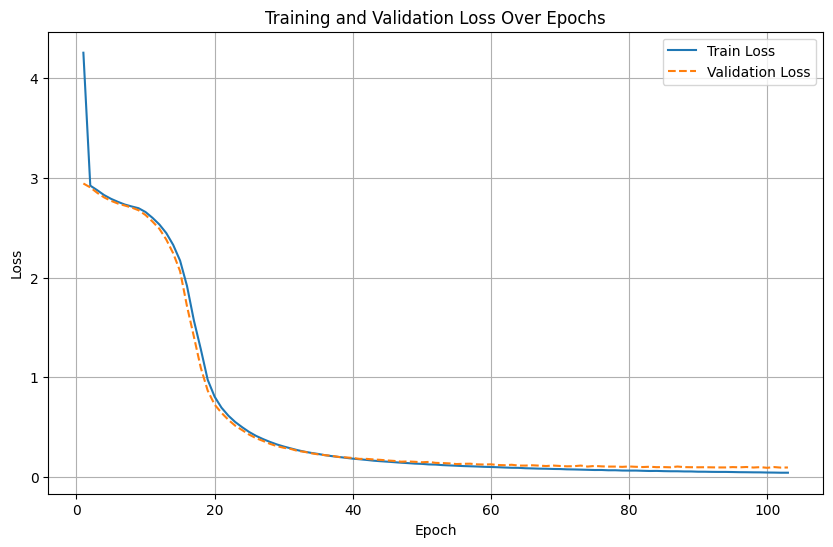

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = "logs/losses_log.csv"
loss_data = pd.read_csv(csv_file_path)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(loss_data["Epoch"], loss_data["Train Loss"], label="Train Loss")
plt.plot(loss_data["Epoch"], loss_data["Validation Loss"], label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.savefig("logs/loss_curve.png")  # Save the plot
plt.show()

In [ ]:
torch.save(model.state_dict(), 'weights_last.pth')
torch.save(model, 'model_last.pth')

In [17]:
gpu = torch.device('cuda:1')
model = torch.load('model_last.pth', weights_only=False)

In [12]:
model = CNN(fc2_out=(len(training_data.classes) + 1))
# model.load_state_dict(torch.load('/home/infres/lotfi-23/training/weights_last.pth'))
model.load_state_dict(torch.load("/home/infres/lotfi-23/training/weights_last.pth", weights_only=True))
model = model.to(gpu)

In [13]:
training_data.classes

['M',
 '9',
 'L',
 '0',
 'J',
 'N',
 'T',
 '7',
 '4',
 'O',
 '1',
 'V',
 'B',
 'Š',
 'Ṯ',
 '6',
 '3',
 '8',
 'Q',
 'D',
 'Ṭ',
 'S',
 '5',
 'Ṣ',
 'A',
 '2',
 'Ž',
 'Y',
 'H']

In [17]:
def label_to_str1(lbl):
    return ''.join([training_data.classes[x-1] if x != 0 else '_' for x in lbl])
    

def label_to_str(lbl):
    # Convert label indices to string
    raw_str = ''.join([training_data.classes[x-1] if x != 0 else '_' for x in lbl])
    
    # Remove consecutive duplicates (excluding '_')
    processed_str = []
    prev_char = None
    for char in raw_str:
        if char != prev_char or char == '_':
            processed_str.append(char)
        prev_char = char
    
    # Remove all '_'
    final_str = ''.join([c for c in processed_str if c != '_'])
    return final_str, raw_str
def greedy_all(output):
    return label_to_str(output[:,:,:].argmax(axis=-1)[:,0])

def eight_most_probable(output):
    m = output[:,:,:].argmax(axis=-1)[:,0]
    p = output[:,:,:].max(axis=-1)[:,0]
    p = p[m != 0]
    m = m[m != 0]
    try:
        ind = p.argpartition(-8)[-8:]
        return label_to_str(m[ind])
    except ValueError:
        # Could not find 8 non-blank characters
        return greedy_all(output)

def beam_search_encode(output, k=8):
    # greedy sarch:
    # ''.join([training_data.classes[x-1] if x != 0 else '' for x in output[:,:,:].argmax(axis=-1)[:,0]])

    trial_seqs = []
    



In [18]:
import numpy as np

def predict(data, strategy='greedy'):
    arr = np.array([data])
    out = model(torch.tensor(arr).to(gpu))
    a2 = out.cpu().detach().numpy()
    if strategy == 'greedy':
        return greedy_all(a2)

    return eight_most_probable(a2)

In [19]:
import numpy as np
inde = 1025
arr = np.array([val_data[inde][0]])
print(arr.shape)
out = model(torch.tensor(arr).to(gpu))
a2 = out.cpu().detach().numpy()

(1, 1, 50, 200)


In [44]:
a2.shape

(50, 1, 25)

In [45]:
eight_most_probable(a2)

('B4JNDMJM', 'B4JNDMJM')

In [46]:
greedy_all(a2)

('JM4JMNBD', 'J_M4J__MN__B_____________________________________D')

In [47]:
np.sum(np.exp(a2))

np.float32(50.0)

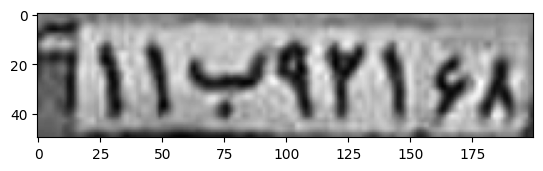

In [50]:
plt.imshow(training_data[1000][0].permute(1,2,0), cmap='gray')

In [51]:
predict(training_data[1000][0])

('MMODYMSL', 'M_MOD__YM__S_____________________________________L')

In [74]:
pred = predict(val_data[1000][0])
pred

'89Q15255'

In [25]:
wrong_count = 0
total = 0
for data, label in val_data:
    total += 1
    l_str = label_to_str1(label)
    # p_str = predict(data, strategy='8')
    o_str, o_seq = predict(data)
    

    if l_str != o_str:
        print(l_str, o_str, o_seq)
        wrong_count+=1
print("wrong count = ", wrong_count)
print("total = ", total)

32D75944 32D75949 3_2D______________________7___5____9___4_________9
14V82134 14V82133 14V_____________________88___2____1____3_________3
24D85820 64D85820 6_4D______________________8___55____8___2________0
34D94188 44H47999 4_4H_______________________4____7___9___9________9
15D14733 75D14734 75D______________________11__4___7___3___________4
55D66H94 5H98288 5_HH_____________________9____8____2____8________8
58Q35555 891H3654 891H_____________________3___6____5______________4
77H27438 77H2748 7_7H_______________________22___77___4___________8
91B71816 51B71816 511B_______________________77___1___88____1______6
92N74633 33N74693 3_3N_______________________7___4___6____9________3
44Y39533 44Y39522 4_4Y_______________________3___9___5___2_________2
35J23855 95J23855 95J____________________2___3___8_____5___________5
85Y76338 75Y76338 75Y_______________________7____6____3_____3______8
18Q92129 88Q92142 8_8Q______________________9___2____1____4________2
26Y53444 76Y53444 7_6Y______________

In [24]:
def test_model_on_validation(model, val_dataset, classes, device):
    """
    Evaluate the model on the validation dataset and print results.
    
    Args:
        model: Trained PyTorch model.
        val_dataset: Validation dataset.
        classes: List of character classes (for decoding).
        device: Device to run inference on (CPU/GPU).
    """
    model.eval()
    correct = 0
    total = 0
    raw_predictions = []
    decoded_predictions = []
    actual_labels = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(val_dataset):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # Shape: (T, N, C)
            outputs = outputs.permute(1, 0, 2)  # Reshape to (N, T, C)
            
            # Decode predictions using greedy decoding
            predictions = outputs.argmax(dim=-1).cpu().numpy()  # (N, T)
            raw_predictions.append(predictions)

            # Decode predictions to strings
            decoded_preds = []
            for pred in predictions:
                decoded_str = ''.join([classes[c - 1] if c != 0 else '_' for c in pred])
                decoded_str = ''.join(ch for i, ch in enumerate(decoded_str) if ch != '_' and (i == 0 or ch != decoded_str[i-1]))
                decoded_preds.append(decoded_str)
            decoded_predictions.extend(decoded_preds)

            # Decode actual labels to strings
            decoded_labels = []
            for label in labels.cpu().numpy():
                decoded_labels.append(''.join([classes[c - 1] if c != 0 else '_' for c in label]))
            actual_labels.extend(decoded_labels)

            # Count correct predictions
            for pred, actual in zip(decoded_preds, decoded_labels):
                if pred == actual:
                    correct += 1
                total += 1

    accuracy = correct / total * 100
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return decoded_predictions, actual_labels, raw_predictions


In [ ]:

decoded_preds, actual_labels, raw_preds = test_model_on_validation(model, val_dataloader, training_data.classes, gpu)